In [1]:
#%pip  install litellm
%load_ext autoreload
%autoreload 2

In [2]:
# Optional: ensure deps (uncomment if needed)
# %pip install -q langgraph langchain-ollama duckdb pandas pyarrow matplotlib langchain-ollama

from Agent.data_agent import SalesDataAgent

# Initialize the agent (uses default data path: data/Store_Sales_Price_Elasticity_Promotions_Data.parquet)
agent = SalesDataAgent(
    model="llama3.2:3b",       # requires Ollama running locally with this model pulled
    temperature=0.1,
    max_tokens=2000,
    streaming=True
)


<module 'langgraph.version' from 'c:\\Python312\\Lib\\site-packages\\langgraph\\version.py'>
DEFAULT_DATA_PATH: c:\Users\Recup\OneDrive\Documentos\Books\PACS\DataAgent\data\Store_Sales_Price_Elasticity_Promotions_Data.parquet
The file exists


In [3]:
agent.check_model()

Server is running locally
Ollama is running locally


True

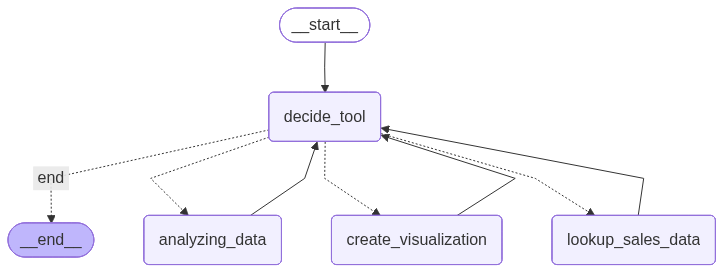

''

In [4]:
agent.draw_graph()

In [5]:
from Agent.data_agent import SalesDataAgent

agent = SalesDataAgent(
    enable_tracing=True,
    phoenix_endpoint="http://localhost:6006/v1/traces",
    project_name="evaluating-agent",
    model="llama3.2:3b"
)
ret = agent.run("What was the most popular product SKU?")
print(ret.get("answer"))

OpenTelemetry Tracing Details
|  Phoenix Project: evaluating-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

Checking the model can run locally
Server is running locally


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

Ollama is running locally
Running the graph...
[LangGraph] Starting LangGraph execution with tracing


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

Tool selected: lookup_sales_data


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

Generated SQL Query:
 SELECT SKU_Coded FROM sales GROUP BY SKU_Coded ORDER BY SUM(Total_Sale_Value) DESC LIMIT 1


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

Tool selected: analyzing_data


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

Data to analyze:
  SKU_Coded
   6200700


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

Tool selected: create_visualization


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

Este es el chart config: {'chart_type': 'bar', 'x_axis': 'SKU_Coded', 'y_axis': '', 'title': 'Most Popular Product SKU', 'data': ' SKU_Coded\n   6200700'}


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

Tool selected: end


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

[LangGraph] LangGraph execution completed


Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Python312\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\urllib3\connectionpool.py", line 495, in _make_request
    conn.request(
  File "c:\Python312\Lib\site-packages\url

['Based on the provided data, it appears that there is only one SKU value: 6200700. Therefore, this value represents the most popular product SKU.\n\nIn other words, since there are no other values in the dataset, we can conclude that the most popular product SKU is indeed 6200700.', "import matplotlib.pyplot as plt\n\ndef create_chart(config):\n    data = config['data'].split('\\n')\n    x_values = [line.split()[0] for line in data]\n    y_values = [int(line.split()[1]) for line in data]\n\n    if config['y_axis']:\n        y_values = [config['y_axis'] + value for value in y_values]\n\n    plt.bar(x_values, y_values)\n    plt.xlabel(config['x_axis'])\n    plt.ylabel(config['y_axis'] or 'Value')\n    plt.title(config['title'])\n\nplt.tight_layout()\nplt.show()"]


In [11]:
from tqdm import tqdm

agent_questions = [
    "What was the most popular product SKU?",
    "What was the total revenue across all stores?",
    "Which store had the highest sales volume?",
    "Create a bar chart showing total sales by store",
    "What was the average transaction value?",
]

for question in tqdm(agent_questions, desc="Processing questions"):
    try:
        ret = agent.run(question)
        print("\nQ:", question)
        if ret.get("error"):
            print("Error:", ret["error"])
            continue
        answer = ret.get("answer", [])
        if answer:
            print("Analysis:\n", answer[0])
            if len(answer) > 1:
                print("\nChart code:\n", answer[1])
        else:
            print("No answer returned.")
    except Exception as e:
        print(f"Error processing question: {question}")
        print(e)
        continue

Processing questions:   0%|          | 0/5 [00:00<?, ?it/s]

Running the graph...
[LangGraph] Starting LangGraph execution with tracing
Tool selected: lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded FROM sales GROUP BY SKU_Coded ORDER BY SUM(Total_Sale_Value) DESC LIMIT 1
Tool selected: analyzing_data
Data to analyze:
  SKU_Coded
   6200700
Tool selected: lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded FROM sales GROUP BY SKU_Coded ORDER BY SUM(Total_Sale_Value) DESC LIMIT 1
Tool selected: analyzing_data
Data to analyze:
  SKU_Coded
   6200700
Tool selected: end


Processing questions:  20%|██        | 1/5 [01:23<05:34, 83.74s/it]

[LangGraph] LangGraph execution completed

Q: What was the most popular product SKU?
Analysis:
 Based on the provided data, it appears that there is only one value for the "SKU_Coded" column. Therefore, it's not possible to determine a most popular product SKU based on this single value.

However, if you provide more data or context, I can help you analyze and answer your question about the most popular product SKU.

Chart code:
 Based on the provided data, it appears that there is only one SKU listed. Therefore, it can be concluded that this SKU is the most popular product SKU, as there are no other SKUs present in the data.

In other words, the most popular product SKU is 6200700, and it has a unique status as the sole entry in the dataset.
Running the graph...
[LangGraph] Starting LangGraph execution with tracing
Tool selected: lookup_sales_data
Generated SQL Query:
 SELECT SUM(Total_Sale_Value) FROM sales
Tool selected: analyzing_data
Data to analyze:
  sum(Total_Sale_Value)
      

Processing questions:  40%|████      | 2/5 [02:56<04:27, 89.27s/it]


Q: What was the total revenue across all stores?
Analysis:
 To analyze the given data, we need to understand that the value "1.327264e+07" represents the sum of Total Sale Values across all stores.

The notation "e+07" indicates that the number is in scientific notation, where:

- "e" stands for the base of the natural logarithm (approximately 2.718)
- The number before "e" is the coefficient
- The number after "e" is the exponent

In this case, "1.327264e+07" can be rewritten as:

1.327264 × 10^7

This means that the total sale value across all stores is approximately 12,727,640.

Therefore, the total revenue across all stores was approximately $12,727,640.

Chart code:
 import matplotlib.pyplot as plt

def create_chart(config):
    data = eval(config['data'])
    x_axis = config['x_axis']
    y_axis = config['y_axis']
    chart_type = config['chart_type']
    title = config['title']

    if chart_type == 'bar':
        plt.bar(x_axis, [data])
        plt.xlabel(x_axis)
        plt.y

Processing questions:  60%|██████    | 3/5 [04:07<02:41, 80.81s/it]

[LangGraph] LangGraph execution completed

Q: Which store had the highest sales volume?
Analysis:
 To determine which store had the highest sales volume, we need more information about the sales data. However, based on the provided data, I can only see that the Store Number is 2970.

Without additional context or data, it's not possible to accurately answer the question of which store had the highest sales volume.

Chart code:
 Based on the provided data, it appears that there is only one row of data, which corresponds to a single store. Therefore, we can conclude that this store is the only one with sales data.

Since there is no comparison or ranking available in the data, we cannot determine which store had the highest sales volume based solely on this information.
Running the graph...
[LangGraph] Starting LangGraph execution with tracing
Tool selected: lookup_sales_data
Generated SQL Query:
 SELECT Store_Number, SUM(Total_Sale_Value) as Total_Sales FROM sales GROUP BY Store_Number


Processing questions:  80%|████████  | 4/5 [08:23<02:29, 149.77s/it]

[LangGraph] LangGraph execution completed

Q: Create a bar chart showing total sales by store
Analysis:
 import matplotlib.pyplot as plt

data = {
    'Store_Number': [4730, 1320, 1540, 3410, 1210, 330, 1760, 1650, 4180, 550, 880, 2860, 2420, 4070, 3080, 2090, 2640, 4840, 3740, 2750, 1980, 2970, 2530, 4400, 770, 3520, 660, 1100, 3190, 3300, 990, 3630, 2310, 2200, 1870],
    'Total_Sales': [239711.708869, 592832.067579, 427777.427815, 410567.848126, 508393.767785, 370503.687331, 350747.617798, 580443.007953, 272208.118542, 229727.498752, 420302.088397, 132320.519487, 406715.767402, 322307.968330, 495458.238811, 309996.247965, 308990.318559, 389056.668316, 359729.808228, 453664.808068, 242290.828499, 836341.327191, 324046.518720, 95745.620250, 292968.918642, 145701.079372, 343594.978075, 497509.528013, 335035.018792, 619660.167018, 378433.018639, 405034.547846, 412579.388504, 361173.288199, 401070.997685]
}

config = {
    'chart_type': 'bar',
    'x_axis': 'Store_Number',
    'y_axis': 

Processing questions: 100%|██████████| 5/5 [09:30<00:00, 114.20s/it]

[LangGraph] LangGraph execution completed

Q: What was the average transaction value?
Analysis:
 The average transaction value is $19.02.

Chart code:
 import matplotlib.pyplot as plt

def plot_chart(config):
    if config['chart_type'] == 'bar':
        data = [float(x) for x in config['data'].split('\n')]
        labels = ['avg(Total_Sale_Value)']
        avg_total_sale_value = data[0]
        
        plt.bar(labels, data)
        plt.xlabel(config['x_axis'])
        plt.ylabel('Value')
        plt.title(config['title'])
    else:
        raise ValueError("Unsupported chart type")
    
    plt.tight_layout()
    plt.show()

config = {'chart_type': 'bar', 'x_axis': 'avg(Total_Sale_Value)', 'y_axis': '', 'title': 'Average Transaction Value', 'data': ' avg(Total_Sale_Value)\n             19.018132'}
plot_chart(config)


In [5]:
from langchain.globals import set_verbose
from langchain.globals import set_debug

set_debug(False)
set_verbose(False)

In [ ]:
#result = agent.run("Show me the sales in Nov 2021")
input_state = {"prompt": "Show me the sales in Nov 2021"}
result = agent.graph.invoke(input_state)

Tool selected: lookup_sales_data
Tool selected: analyzing_data


In [ ]:
result = agent.run("Show me the sales in Nov 2021")

Checking the model can run locally
Server is running locally
Ollama is running locally
Running the graph...


In [ ]:
# Run a prompt; optionally pass a visualization goal
result = agent.run("Show me the sales in Nov 2021")

# Inspect results
print("Final tool:", result.get("tool_choice"))
print("Chart config:", result.get("chart_config"))
print("\nNumber of answer steps:", len(result.get("answer", [])))
if result.get("answer"):
    print("\nAnalysis (first 500 chars):\n", result["answer"][0][:500])

# If the last answer item is plotting code, execute it to render the chart
if result.get("chart_config") and result.get("answer"):
    chart_code = result["answer"][-1]
    exec(chart_code, globals(), locals())

Running the graph...


KeyboardInterrupt: 

In [ ]:
print(agent.llm.invoke('hi'))

content='How can I assist you today?' additional_kwargs={} response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-10-26T14:55:03.8307549Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1417956800, 'load_duration': 239529800, 'prompt_eval_count': 26, 'prompt_eval_duration': 184507600, 'eval_count': 8, 'eval_duration': 976263200, 'model_name': 'llama3.2:3b'} id='run--64135ac3-7e01-4589-84d8-27debe03e542-0' usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34}
